# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from tifffile import imread

from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse skull nuclei/Mouse skull nuclei/'

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [3]:
dataName = 'mouseskullnuclei' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [4]:
# Load the network, created in the '1_CareTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR CARE 36.24646759383874
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR CARE 36.38973289771564
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR CARE 36.407220567726576
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR CARE 36.45259335294489
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR CARE 36.32256597442939
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR CARE 36.45310590551399
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR CARE 36.53072377558223
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR CARE 36.455612898812454
-----------------------------------
image: 8
PSNR input 28.074885947043384
PSNR CARE 36.529001027618555
-----------------------------------
image: 9
PSNR input 28.07332624770129
PSNR CARE 36.5065773318383
---------

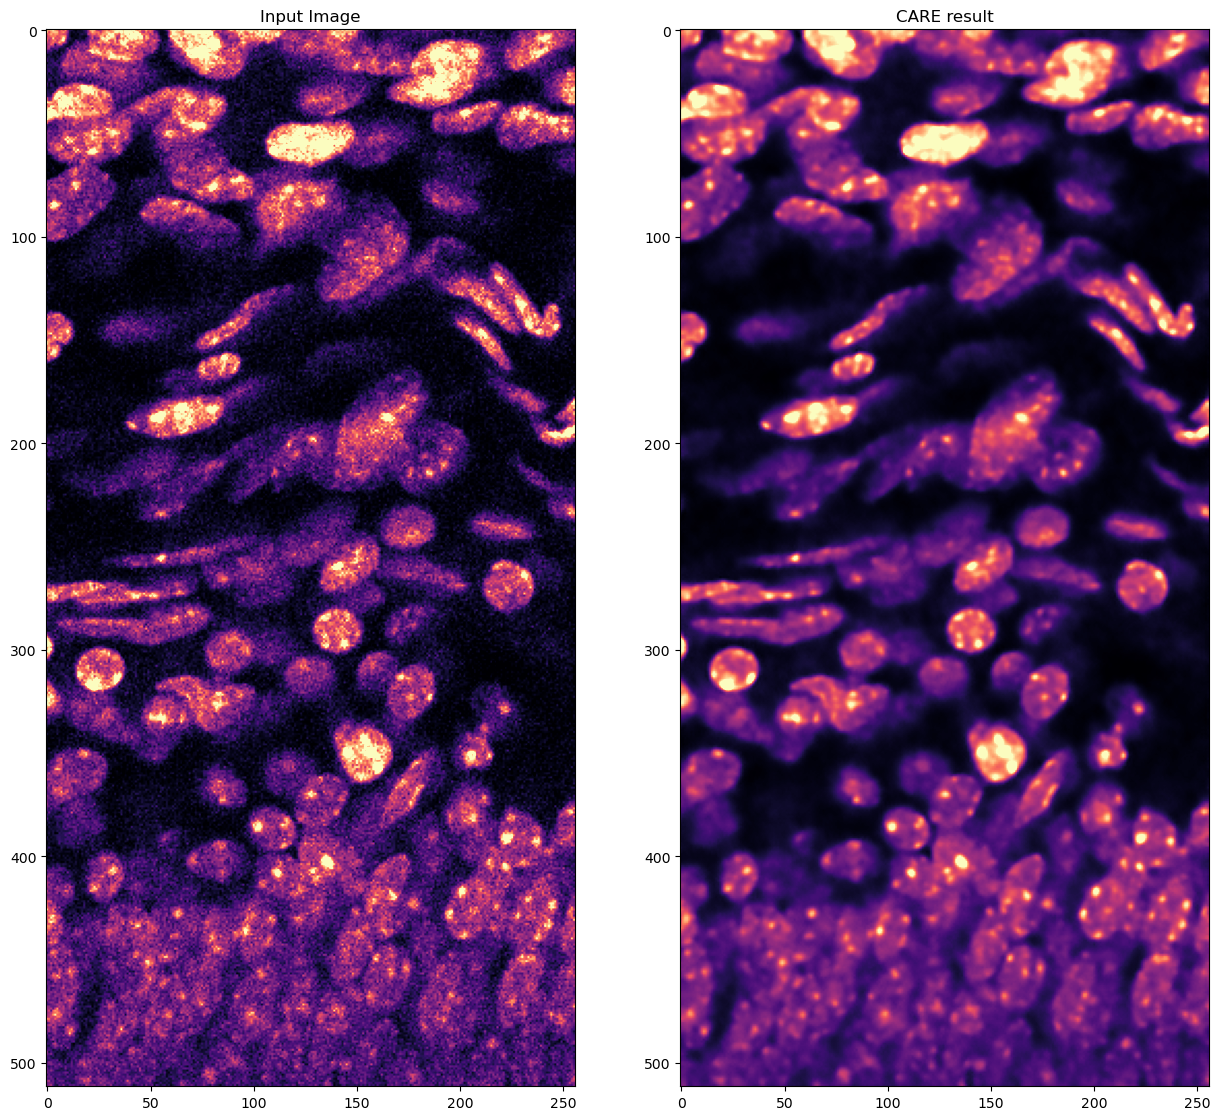

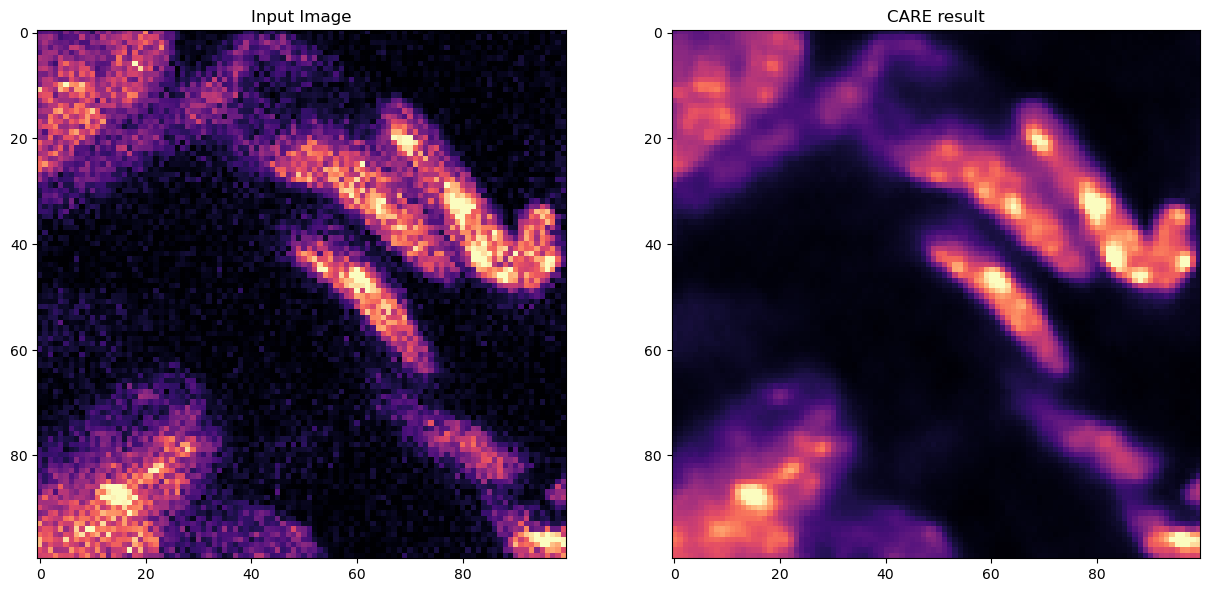

Avg PSNR CARE: 36.51578074516805 +-(2SEM) 0.009869456951387077


In [5]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult,rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )